In [450]:
from pandas import json_normalize
import pandas as pd
import json
import numpy
from sklearn.cluster import MiniBatchKMeans
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import operator
import random
import matplotlib.image as mpimg

### Partie Analyse

On a précedemment créé les différents labels pour chaque tableau, initialisé les différents utilisateurs. On peut maintenant analyser les donnés et en déduire d'autres informations qui nous serviront à faire les recommandations pour les utilisateurs.

In [451]:
#ouverture des fichiers précédemment créés
with open("label.json",'r') as jsonTab:
    dataTab = json.load(jsonTab)
dataframeTab = json_normalize(dataTab)

with open("user.json",'r') as jsonUser:
    dataUser = json.load(jsonUser)
dataframeUser = json_normalize(dataUser)

In [452]:
n = int(input("Vous souhaiter visualiser les données de l'utilisateur n° ? (entre 0 et 99)"))
if n not in range(99):
    print("Nombre invalide, le script va sûrement planter")

On commence par déterminer la couleur préférée de l'utilisateur, qui va nous permettre de réaliser une recommandation précise.

In [453]:
#détermination des couleurs et des formats préférés de l'utilisateur en fonction des likes
couleursPref = []
listeFormat = []
compteFormat = []
#récupération des couleurs dominantes des tableaux likés par l'utilisateur 0
for tab in dataTab:
    if tab['lien'] in dataUser[n]['likes']:
        couleursPref.append(tab['couleur'])
        format = tab['format']
        if format in listeFormat:
            compteFormat[listeFormat.index(format)]+=1
        else:
            compteFormat.append(1)
            listeFormat.append(format)

formatPref=listeFormat[compteFormat.index(max(compteFormat))]
dataUser[n]['formatPref']=formatPref

On utilise une fonction KMeans car une moyenne de toutes les couleurs résulterait en une couleur moyenne ~=[122,122,122]. On utilise après un histogramme pour classer les couleurs, et obtenir la couleur qui est la plus représentée sur l'image.

In [454]:

#partitionement des couleurs dominantes de tous les tableaux en 3 cluster
couleursPref = MiniBatchKMeans(3).fit(couleursPref)
#création d'un numpyarray
npbins = numpy.arange(0, 4)
#création d'un histogramme qui classe les clusters par odre croissant
histogram = numpy.histogram(couleursPref.labels_, bins=npbins)
imax = numpy.argmax(histogram[0])

R = math.ceil(couleursPref.cluster_centers_[imax][0])
G = math.ceil(couleursPref.cluster_centers_[imax][1])
B = math.ceil(couleursPref.cluster_centers_[imax][2])

dataUser[n]['couleurPref']=[R,G,B]


On détermine également le tag préféré de chaque utilisateur, afin de pouvoir lui recommander un tableau qui lui corresponde au mieux.
Nous n'utilisons pas cette partie de code dans la suite du projet car on se basera sur d'autres critères. Cepndant, l'algorithme étant intéressant, nous avons décidé de le laisser dans le notebook.<br>
On écrit ensuite ces changements dans le fichier JSON.


In [455]:
#détermination du tag préféré de l'utilsateur
listeTag=[]
compteTag=[]
for tableau in dataUser[n]['tags']:
    tag=dataUser[n]['tags'][tableau]
    if tag in listeTag:
        compteTag[listeTag.index(tag)]+=1
    else:
        compteTag.append(1)
        listeTag.append(tag)

tagPref=listeTag[compteTag.index(max(compteTag))]
dataUser[n]['tagPref']=tagPref


jsonUser=open("user.json",'w')
jsonUser.write(json.dumps(dataUser, ensure_ascii=False))
jsonUser.close()

### Partie Visualisation

##### Pour pouvoir visualiser les données, et réaliser des classifications on utilise les dataframes de la bibliothèque pandas.

On commence par créer les différents dataframes.

In [456]:
with open("label.json",'r') as jsonTab:
    dataTab = json.load(jsonTab)
dataframeTab = json_normalize(dataTab)

with open("user.json",'r') as jsonUser:
    dataUser = json.load(jsonUser)
dataframeUser = json_normalize(dataUser)

arrayAuteur = []
arrayFormat = []
arrayLikes = []
arrayCouleur = []
for data in dataTab :
    arrayAuteur.append([data['auteur'],data['lien']])
    arrayFormat.append([data['format'],data['lien']])
    arrayLikes.append([data['likes'],data['lien']])
    arrayCouleur.append(data['couleur'])
dataframeAuteur = pd.DataFrame(arrayAuteur, columns=['auteur','lien'])
dataframeFormat = pd.DataFrame(arrayFormat, columns=['format','lien'])
dataframeLikes = pd.DataFrame(arrayLikes, columns=['likes','lien'])
couleursDom = pd.DataFrame(arrayCouleur, columns=['R','G','B'])

On réalise les différents groupby afin d'obtenir les différentes données à utiliser : nombre de tableaux par auteur, par format et par likes.

In [457]:
grouped=dataframeAuteur.groupby("auteur").count()
grouped = grouped.rename(
    columns={'lien':'count'}).reset_index()

grouped2 = dataframeFormat.groupby("format").count()
grouped2 = grouped2.rename(
    columns={'lien':'count'}).reset_index()

grouped3 = dataframeLikes.groupby("likes").count()
grouped3 = grouped3.rename(
    columns={'lien':'count'}).reset_index()

On représente ensuite les couleurs les plus représentées dans nos tableaux.

In [458]:
nbcluster = 5
clusters = MiniBatchKMeans(nbcluster).fit(couleursDom)
#création d'un numpyarray
npbins = numpy.arange(0, nbcluster + 1)
#création d'un histogramme qui classe les clusters par odre croissant
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)

histogram[0][::-1].sort() #permet d'inverser le tri (ordre décroissant)

colors = []
for i in range(nbcluster):
    colors.append('#%02x%02x%02x' % (
    math.ceil(clusters.cluster_centers_[i][0]), 
        math.ceil(clusters.cluster_centers_[i][1]),
    math.ceil(clusters.cluster_centers_[i][2])))


On affiche maintenant les différents éléments : un 'pie chart' pour représenter les couleurs, et des diagrammes bâtons pour les informations sur les labels.

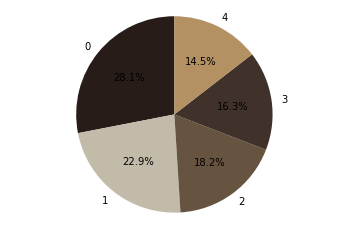

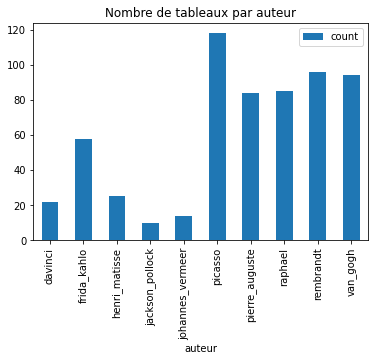

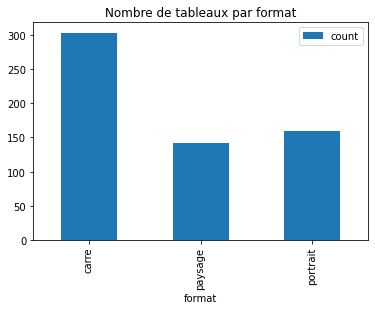

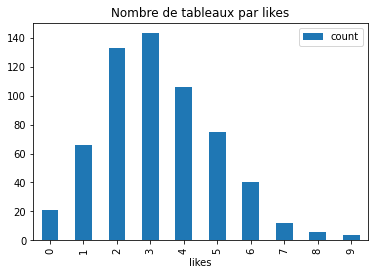

In [459]:
fig1, ax1 = plt.subplots()
ax1.pie(histogram[0],labels=labels, autopct='%1.1f%%', startangle=90, colors=colors) #autopct permet d'avoir des pourcentages
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

grouped.plot(x=0, kind='bar', title="Nombre de tableaux par auteur")
grouped2.plot(x=0, kind='bar', title="Nombre de tableaux par format")
grouped3.plot(x=0, kind='bar', title="Nombre de tableaux par likes")
plt.show()

### Partie Recommandation

On réalise les recommandations pour les utilisateurs. Ici l'exemple sera fait sur l'utilisateur choisi en début de programme.

On crée une fonction ComparaisonCouleur, que nous utiliserons pour déterminer si deux couleurs sont proches ou non. Plus le résultat est proche de zéro, plus les couleurs sont proches.

In [460]:
#Fonction de comparaison de couleurs
#Entrées : deux codes RGB de deux couleurs
#Sorties : un indice de proximité des couleurs
def ComparaisonCouleur(couleur1, couleur2):
    dif = []
    for i in range (3):
        dif.append(couleur1[i] - couleur2[i])
    #mise au carré pour être sûr d'avoir des valeurs de diférence positive 
    return dif[0]**2+dif[1]**2+dif[2]**2

On crée ensuite les dataframes que nous donnerons à notre algorithme de classification. On crée donc deux dataframes : celui avec les tableaux (on mettra les différents paramètres de comparaison : auteur, format et tag le plus utilisé) et le dataframe result qui sera composé de 1 (le tableau a été liké) et de -1 (le tableau a été vu mais non liké).

In [461]:
data=[]
result=[]
auteur_vu=[]

with open("label.json",'r') as jsonTab:
    dataTab = json.load(jsonTab)

dataTabCustom = dataTab.copy()
for lien in dataUser[n]["likes"]: #on construit un dataframe qui va servir à l'algo de classification : on commence par les tableaux likés par l'utilisateur (result = 1)
    for tableau in dataTab:
        if lien == tableau["lien"]:
            tag = max(tableau["tags"].items(), key=operator.itemgetter(1))[0] #l'algo ne prend pas de liste de tags en paramètre: on choisit donc le tag le plus utilisé sur le tableau
            data.append([tableau["auteur"],tableau["format"],tag])
            result.append(1)
            auteur_vu.append(tableau["auteur"])
            dataTabCustom.remove(tableau)
            

for lien in dataUser[n]["unlikes"]:#on fait la même chose avec les tableaux vu et non likés (result = -1)
    for tableau in dataTab:
        if lien == tableau["lien"]:
            tag = max(tableau["tags"].items(), key=operator.itemgetter(1))[0]
            data.append([tableau["auteur"],tableau["format"],tag])
            result.append(-1)
            auteur_vu.append(tableau["auteur"])
            dataTabCustom.remove(tableau)

ValueError: list.remove(x): x not in list

On lance maintenant notre algorithme de classification : on utilise l'algorithme DecisionTreeClasifier, qui nous permetttra de réaliser des prédictions (l'utilisateur est susceptible d'aimer ou non le tableau).
On commence par encoder les labels pour que l'algorithme puisse les comprendre, puis on fourni les dataframes à l'algorithme.

In [ ]:
dataframe = pd.DataFrame(data, columns=['auteur', 'format', 'tags'])#construction des dataframes
resultframe = pd.DataFrame(result, columns=['like'])

le1 = LabelEncoder() #encodage des labels
dataframe['auteur'] = le1.fit_transform(dataframe['auteur'])

le2 = LabelEncoder()
dataframe['format'] = le2.fit_transform(dataframe['format'])

le3 = LabelEncoder()
dataframe['tags'] = le3.fit_transform(dataframe['tags'])

le4 = LabelEncoder()
resultframe['like'] = le4.fit_transform(resultframe['like'])

#On utilise les classifieurs "arbres"
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(dataframe, resultframe)

On réalise maintenant des recommandations jusqu'à avoir 10 recommandations à faire à l'utilisateur. On a supprimé les warnings généré par l'algorithme grâce aux deux premières lignes.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

recommandation = [] #on initialise une liste de tableaux recommandés
non_recommandation=[] #on initialise une liste de tableaux non-recommandés
while len(recommandation)<10 and len(dataTabCustom)>0:
    tab = random.choice(dataTabCustom)
    if tab["auteur"] not in auteur_vu: #l'algo de prédiction plante si on lui présente un tableau dont l'auteur est n'a pas été vu par l'utilisateur.
        continue
    prediction = dtc.predict([ #on réalise une prédiction pour savoir si le tableau plaira à l'utilisateur
            [le1.transform([tab["auteur"]])[0], le2.transform([tab["format"]])[0],
            le3.transform([max(tableau["tags"].items(), key=operator.itemgetter(1))[0]])[0]]])
    if prediction == 1: 
        recommandation.append(tab)
    else:
        non_recommandation.append(tab)
    dataTabCustom.remove(tab)

On rajoute maintenant le paramètre de la couleur, afin de pouvoir proposer à l'utilisateur le tableau dont la couleur dominante est la plus proche de sa couleur préférée.

In [ ]:
for tab in recommandation: #on ajoute une comparaison par couleurs des tableaux, afin d'avoir la recommandation la plus précise possible
    tab["indice_couleur"]=ComparaisonCouleur(dataUser[n]["couleurPref"],tab["couleur"])

dataframe=pd.DataFrame(recommandation)
dataframe.drop(columns=["auteur",'largeur','hauteur','format','tags','unlikes','couleur'],inplace=True)
dataframe.sort_values(by="indice_couleur",inplace=True)
if dataframe.iloc[0]['indice_couleur']>200 :
    dataframe.sort_values(by="likes",inplace=True)

#### Affichage des recommandations

On affiche les images likés de l'utilisateur, puis les recommandations que nous pouvons faire grâce aux algorithmes.

Vos Infos : 
Votre couleur préférée :  [48, 34, 27]
Votre tag préférée :  aquarelle 

Images likés : 


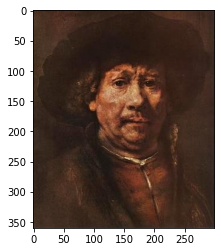

Auteur :  rembrandt
Tags :  {'impressionnisme': 1, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 2
Format :  portrait
Couleur :  [60, 39, 29]


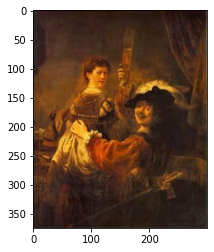

Auteur :  rembrandt
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 2, 'decevant': 2, "chef-d'oeuvre": 3, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 6
Format :  portrait
Couleur :  [67, 41, 27]


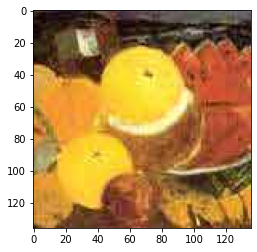

Auteur :  frida_kahlo
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 2, 'printanier': 1}
Nombres de likes : 3
Format :  carre
Couleur :  [123, 74, 42]


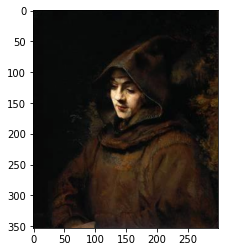

Auteur :  rembrandt
Tags :  {'impressionnisme': 1, 'abstrait': 0, 'emouvant': 1, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 2
Format :  portrait
Couleur :  [15, 13, 11]


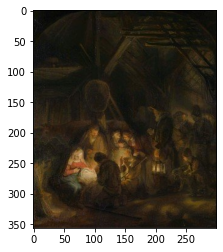

Auteur :  rembrandt
Tags :  {'impressionnisme': 0, 'abstrait': 2, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 5
Format :  portrait
Couleur :  [34, 28, 18]


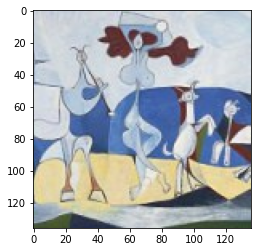

Auteur :  picasso
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 2, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 2, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 5
Format :  carre
Couleur :  [203, 207, 203]


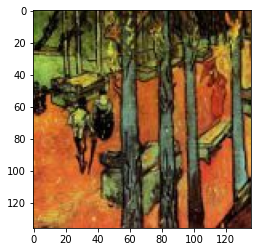

Auteur :  van_gogh
Tags :  {'impressionnisme': 1, 'abstrait': 1, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 4
Format :  carre
Couleur :  [175, 119, 64]


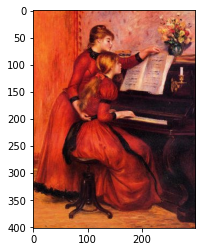

Auteur :  pierre_auguste
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 2
Format :  portrait
Couleur :  [209, 91, 60]


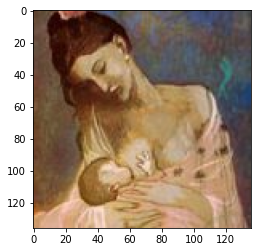

Auteur :  picasso
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 2, 'printanier': 0}
Nombres de likes : 1
Format :  carre
Couleur :  [96, 74, 61]


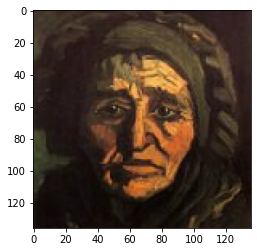

Auteur :  van_gogh
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 1, "chef-d'oeuvre": 2, 'acrylique': 0, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 4
Format :  carre
Couleur :  [45, 33, 26]


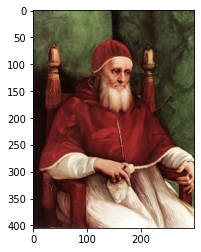

Auteur :  raphael
Tags :  {'impressionnisme': 0, 'abstrait': 2, 'emouvant': 0, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 3
Format :  portrait
Couleur :  [83, 50, 36]


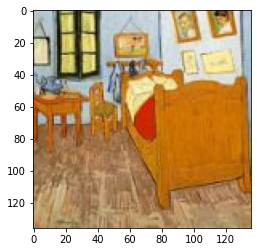

Auteur :  van_gogh
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 2, 'decevant': 1, "chef-d'oeuvre": 2, 'acrylique': 1, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 6
Format :  carre
Couleur :  [169, 114, 52]


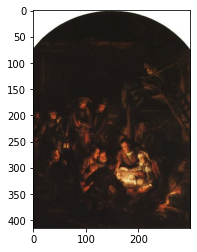

Auteur :  rembrandt
Tags :  {'impressionnisme': 2, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 1, 'acrylique': 1, 'aquarelle': 2, 'printanier': 0}
Nombres de likes : 6
Format :  portrait
Couleur :  [41, 30, 25]


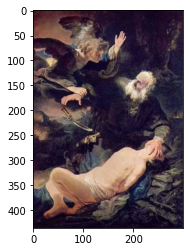

Auteur :  rembrandt
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 1, 'acrylique': 0, 'aquarelle': 2, 'printanier': 1}
Nombres de likes : 4
Format :  portrait
Couleur :  [46, 33, 50]


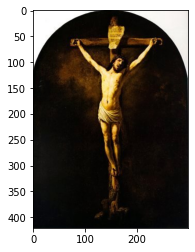

Auteur :  rembrandt
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 2
Format :  portrait
Couleur :  [23, 15, 8]


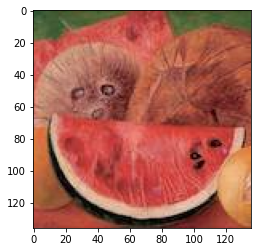

Auteur :  frida_kahlo
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 2, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 3
Format :  carre
Couleur :  [199, 105, 88]


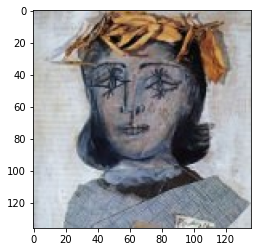

Auteur :  picasso
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 4
Format :  carre
Couleur :  [175, 176, 180]


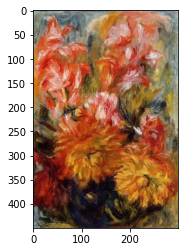

Auteur :  pierre_auguste
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 0, "chef-d'oeuvre": 1, 'acrylique': 1, 'aquarelle': 1, 'printanier': 1}
Nombres de likes : 5
Format :  portrait
Couleur :  [182, 126, 86]


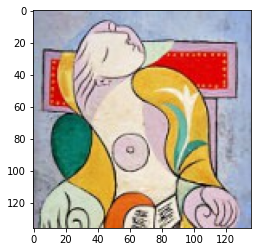

Auteur :  picasso
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 3
Format :  carre
Couleur :  [196, 191, 193]


In [ ]:
print("Vos Infos : ")
print("Votre couleur préférée : ",dataUser[n]["couleurPref"])
print("Votre tag préférée : ",dataUser[n]["tagPref"],"\n")

print('Images likés : ')
for i in range(len(dataUser[n]["likes"])):
    img = mpimg.imread(dataUser[n]["likes"][i])
    imgplot=plt.imshow(img)
    plt.show()
    for tab in dataTab:
        if tab['lien'] == dataUser[n]["likes"][i]:
            print('Auteur : ',tab['auteur'])
            print('Tags : ',tab['tags'])
            print('Nombres de likes :',tab['likes'])
            print('Format : ',tab['format'])
            print('Couleur : ',tab['couleur'])
            break
    

Notre recommandation : 


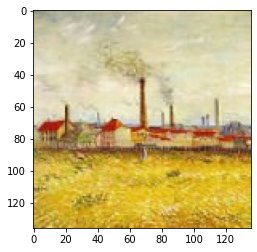

Auteur :  van_gogh
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 1
Format :  carre
Couleur :  [216, 210, 175]


In [ ]:
print('Notre recommandation : ')
img = mpimg.imread(dataframe.iloc[0]['lien'])
imgplot = plt.imshow(img)
plt.show()
for tab in dataTab:
        if tab['lien'] == dataframe.iloc[0]['lien']:
            print('Auteur : ',tab['auteur'])
            print('Tags : ',tab['tags'])
            print('Nombres de likes :',tab['likes'])
            print('Format : ',tab['format'])
            print('Couleur : ',tab['couleur'])
            break


Les tableaux qui pourraient aussi vous plaire : 


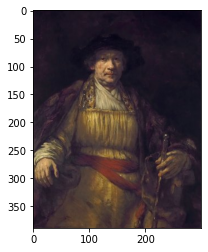

Auteur :  rembrandt
Tags :  {'impressionnisme': 1, 'abstrait': 1, 'emouvant': 1, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 3
Format :  portrait
Couleur :  [38, 28, 40]


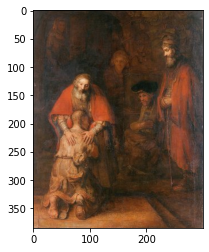

Auteur :  rembrandt
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 1, 'acrylique': 0, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 3
Format :  portrait
Couleur :  [71, 52, 37]


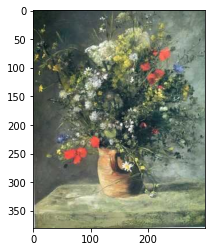

Auteur :  pierre_auguste
Tags :  {'impressionnisme': 1, 'abstrait': 0, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 3
Format :  portrait
Couleur :  [76, 85, 74]


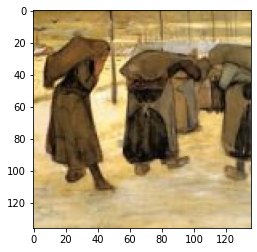

Auteur :  van_gogh
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 0, "chef-d'oeuvre": 1, 'acrylique': 0, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 3
Format :  carre
Couleur :  [210, 184, 128]


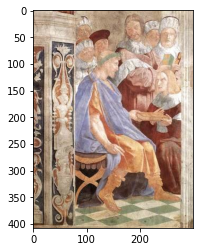

Auteur :  raphael
Tags :  {'impressionnisme': 0, 'abstrait': 2, 'emouvant': 0, 'decevant': 0, "chef-d'oeuvre": 0, 'acrylique': 1, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 3
Format :  portrait
Couleur :  [199, 175, 157]


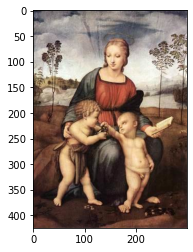

Auteur :  raphael
Tags :  {'impressionnisme': 0, 'abstrait': 1, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 1, 'printanier': 0}
Nombres de likes : 4
Format :  portrait
Couleur :  [78, 53, 44]


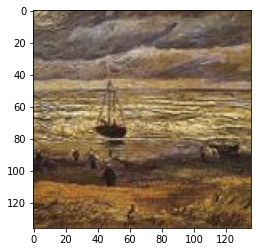

Auteur :  van_gogh
Tags :  {'impressionnisme': 0, 'abstrait': 1, 'emouvant': 1, 'decevant': 3, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 0}
Nombres de likes : 4
Format :  carre
Couleur :  [103, 79, 56]


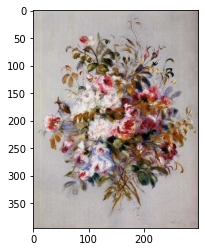

Auteur :  pierre_auguste
Tags :  {'impressionnisme': 1, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 0, 'acrylique': 0, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 4
Format :  portrait
Couleur :  [187, 178, 176]


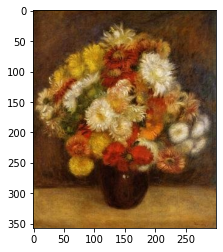

Auteur :  pierre_auguste
Tags :  {'impressionnisme': 0, 'abstrait': 0, 'emouvant': 1, 'decevant': 1, "chef-d'oeuvre": 2, 'acrylique': 0, 'aquarelle': 0, 'printanier': 1}
Nombres de likes : 5
Format :  portrait
Couleur :  [88, 50, 23]


In [ ]:
print("Les tableaux qui pourraient aussi vous plaire : ")
for i in range(9):
    img = mpimg.imread(dataframe.iloc[i+1]['lien'])
    imgplot = plt.imshow(img)
    plt.show()
    for tab in dataTab:
        if tab['lien'] == dataframe.iloc[i+1]['lien']:
            print('Auteur : ',tab['auteur'])
            print('Tags : ',tab['tags'])
            print('Nombres de likes :',tab['likes'])
            print('Format : ',tab['format'])
            print('Couleur : ',tab['couleur'])
            break